<a href="https://colab.research.google.com/github/Vidi005/Klasifikasi-Beras-Satuan/blob/master/Klasifikasi%20Beras%20Satuan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Klasifikasi Jenis Beras

# **Mengambil Dataset dari Github**

In [0]:
!apt-get install subversion > /dev/null

!svn export https://github.com/Vidi005/Klasifikasi-Beras-Satuan/trunk/data > /dev/null
!svn export https://github.com/Vidi005/Klasifikasi-Beras-Satuan/trunk/utils > /dev/null
!svn export https://github.com/Vidi005/Klasifikasi-Beras-Satuan/trunk/Klasifikasi-Beras-Satuan.ipynb > /dev/null

svn: E170000: URL 'https://github.com/Vidi005/Klasifikasi-Beras-Satuan/trunk/Klasifikasi-Beras-Satuan.ipynb' doesn't exist


## Persiapan

Program ini dibuat untuk membedakan 2 jenis beras berdasarkan ukuran panjang dan lebarnya

![ ](https://github.com/Vidi005/Klasifikasi-Beras-Satuan/trunk/data/image/test/pendek/C1.jpg) Ukuran beras pendek (Cilamaya)

![ ](https://github.com/Vidi005/Klasifikasi-Beras-Satuan/trunk/data/image/test/pendek/I1.jpg) Ukuran beras sedang (IR 64)

Program ini menggunakan 3 macam cara untuk melakukan klasifikasinya, pada cara 1 dan 2 menggunakan klasifikasi dengan membuat fitur secara manual, dan pada cara 3 mengimplementasikan metode deep learning. Namun, untuk klasifikasi beras dengan dua jenis ini masih bisa dilakukan dengan menggunakan cara 1 dan 2, tetapi akan jauh lebih baik hasilnya dengan cara 3.

Cara 1. Klasifikasi Manual dengan Pendekatan Konvensional

Cara 2. Klasifikasi Berdasarkan SVM (Support Vector Machine)

Cara 3. Klasifikasi dengan CNN (Convolutional Neural Network.

Klik tombol run di setiap sel dari atas ke bawah dan semuanya akan berjalan dengan baik.
jika Anda tidak ingin melihat hasil sebelumnya, klik "edit" dan pilih "hapus semua output sel".


## Memasukan Fungsi Library

In [0]:
import numpy as np 
import math, os, sys
import itertools

import matplotlib.pyplot as plt
plt.style.use('default')
from scipy import ndimage

from skimage import measure, morphology
from skimage.io import imsave, imread
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.transform import resize

from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
import pandas as pd

In [0]:
#functions to assist visualizations

#confusion matrix drawing function provided by sklearn
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    #code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    #code from https://scikit-learn.org/stable/auto_examples/svm/plot_iris.html#sphx-glr-auto-examples-svm-plot-iris-py
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = plt.contourf(xx, yy, Z, **params)
    return out

## Mengimpor Dataset

In [0]:
#this command below see inspects part of the files which have been downloaded from the cell above
!ls data/image
!ls data/image/train
!ls data/image/train/pendek
!ls data/image/train/sedang

test  test.txt	train  train.txt
pendek	sedang
C10.jpg  C13.jpg  C16.jpg  C19.jpg  C21.jpg  C24.jpg  C3.jpg  C6.jpg  C9.jpg
C11.jpg  C14.jpg  C17.jpg  C1.jpg   C22.jpg  C25.jpg  C4.jpg  C7.jpg
C12.jpg  C15.jpg  C18.jpg  C20.jpg  C23.jpg  C2.jpg   C5.jpg  C8.jpg
I10.jpg  I13.jpg  I16.jpg  I19.jpg  I21.jpg  I24.jpg  I3.jpg  I6.jpg  I9.jpg
I11.jpg  I14.jpg  I17.jpg  I1.jpg   I22.jpg  I25.jpg  I4.jpg  I7.jpg
I12.jpg  I15.jpg  I18.jpg  I20.jpg  I23.jpg  I2.jpg   I5.jpg  I8.jpg


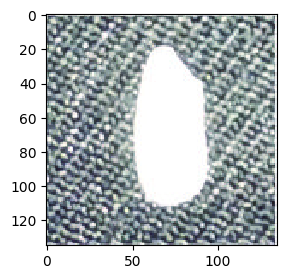

In [0]:
#let's visualize a single file
image = imread("data/image/train/pendek/C2.jpg")
plt.figure(figsize=(3,3))
plt.imshow(image)

In [0]:
#lets load everything into memory first

#load training dataset
X_train = []
y_train = []

for root, dirs, files in os.walk("data/image/train"):
    files = [x for x in files if x.endswith(".jpg")]
    for file in files:
        image_path = os.path.join(root, file)
        
        image = imread(image_path)/255.
        image = resize(image,(32,32))
        X_train.append(image)        
        category = os.path.split(root)[-1]
        if category == "pendek":
            y_train.append(0)
        else:
            y_train.append(1)
X_train = np.array(X_train)
y_train = np.array(y_train)



#load test dataset
X_test = []
y_test = []

for root, dirs, files in os.walk("data/image/test"):
    files = [x for x in files if x.endswith(".jpg")]
    for file in files:
        image_path = os.path.join(root, file)
        
        image = imread(image_path)/255.
        image = resize(image,(32,32))
        X_test.append(image)        
        category = os.path.split(root)[-1]
        if category == "pendek":
            y_test.append(0)
        else:
            y_test.append(1)
X_test = np.array(X_test)
y_test = np.array(y_test)

print("train dataset shape is:", X_train.shape,y_train.shape)
print("test dataset shape is:", X_test.shape,y_test.shape)

train dataset shape is: (50, 32, 32, 3) (50,)
test dataset shape is: (10, 32, 32, 3) (10,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


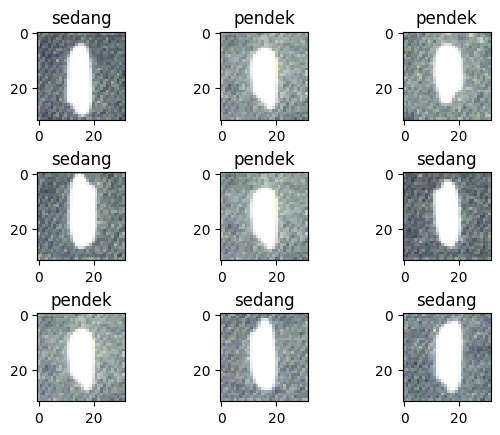

In [0]:
plt.subplots_adjust(wspace=0.4, hspace=0.6)

#randomly show several images from the training dataset
index = np.random.randint(0,X_train.shape[0],size=9)

for i, idx  in enumerate(index):
    plt.subplot(3,3,i+1)
    
    if y_train[idx] == 0:
        label = "pendek"
    else:
        label = "sedang"
    plt.title(label)
    plt.imshow(X_train[idx])

# Cara 1 Klasifikasi Secara Manual

Lets manually define the feature for classification. In this case, simply binarizing the image, extracting the area size of each image and then defining a threshold will do well. All of the image transformation and area measuring can be done with the functions of skimage and scipy.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(32, 32, 3)


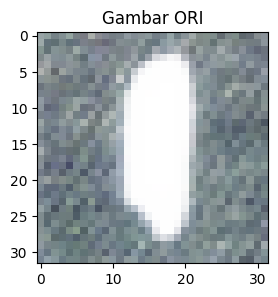

In [0]:
#Let's try it for one image
image = X_train[0]

#the original image
print(image.shape)
plt.figure(figsize=(3,3))
plt.imshow(image)
plt.title("Gambar Asli")
plt.show()

(32, 32)


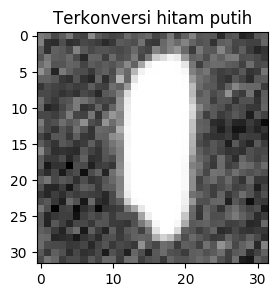

In [0]:
#gray conversion
gray = rgb2gray(image)
print(gray.shape)
plt.figure(figsize=(3,3))
plt.imshow(gray, cmap=plt.cm.gray)
plt.title("Terkonversi hitam putih")
plt.show()

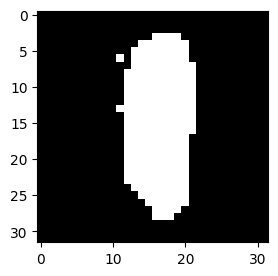

In [0]:
#binary conversion
threshold = threshold_otsu(gray)
binary = gray > threshold
plt.figure(figsize=(3,3))
plt.imshow(binary, cmap=plt.cm.gray)
plt.show()

now that we have a nice binary image, we can isolate the region of rice seed which corresponds to the white region of the image above.

In [0]:
label_im, nb_labels = ndimage.label(binary)
regionprops = measure.regionprops(label_im, intensity_image=gray)
regionprop = regionprops[0]

print("area is",regionprop.area)
print("major axis length is", regionprop.major_axis_length)
print("minor axis length is", regionprop.minor_axis_length)

area is 218
major axis length is 26.881551099416853
minor axis length is 10.488329403887805


/usr/local/lib/python3.6/dist-packages/skimage/measure/_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
/usr/local/lib/python3.6/dist-packages/skimage/measure/_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)


In [0]:
#bundling the above into a function
def quantify_area(image):
    gray = rgb2gray(image)
    threshold = threshold_otsu(gray)
    binary = gray > threshold
    label_im, nb_labels = ndimage.label(binary)
    regionprops = measure.regionprops(label_im, intensity_image=gray)
    regionprop = regionprops[0]
    area = regionprop.area
    return area

#test
area = quantify_area(image)
print(area)

218


In [0]:
X_train_area = []
for image in X_train:
    area = quantify_area(image)
    X_train_area.append(area)

X_test_area = []
for image in X_test:
    area = quantify_area(image)
    X_test_area.append(area)

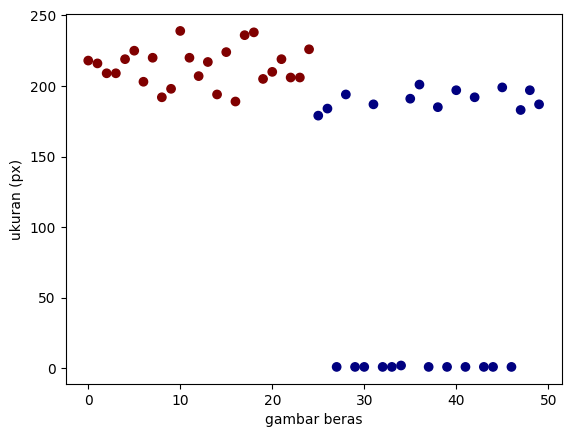

In [0]:
#check the calculated data area value of training dataset

plt.scatter(range(len(X_train_area)),X_train_area,c=y_train,cmap="jet")
plt.xlabel("gambar beras")
plt.ylabel("ukuran (px)")
plt.show()

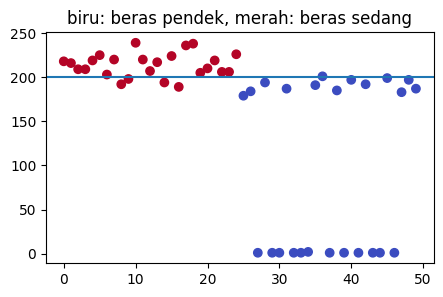

Confusion matrix, without normalization


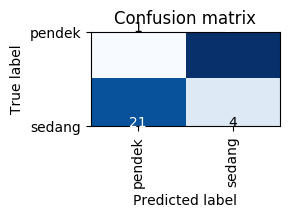

In [0]:
#define an area threshold that can seperate the two classes
#must change from the default value or it won't seperate nicely.
#run this code once and try the suitable value that can seperate blue and red with the horizontal lines
area_threshold = 200


#classify whether the image is a proper seed or a broken seed according to the area_threshold value
train_y_pred = []
for area in X_train_area:
    if area > area_threshold:
        train_y_pred.append(0)
    else:
        train_y_pred.append(1)
        

#plot scatter with threshold line
plt.figure(figsize=(5,3))
plt.scatter(range(len(X_train_area)),X_train_area,c=y_train,cmap=plt.cm.coolwarm)
plt.axhline(y=area_threshold)
plt.title("biru: beras pendek, merah: beras sedang")
plt.show()

#calculate confusion matrix
cnf = confusion_matrix(y_train, train_y_pred)

#confusion matrix in figure
plt.figure(figsize=(3,3))
plot_confusion_matrix(cnf, classes=["pendek","sedang"])

plt.show()

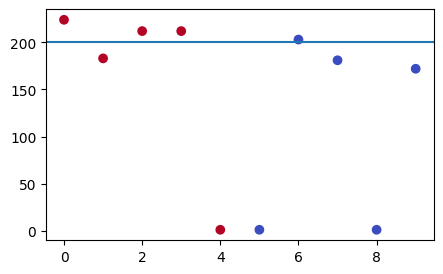

Confusion matrix, without normalization


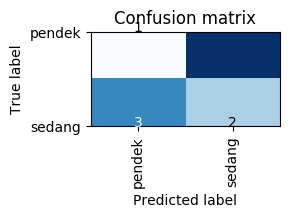

In [0]:
#evaluate it with the test dataset
test_y_pred = []
for area in X_test_area:
    if area > area_threshold:
        test_y_pred.append(0)
    else:
        test_y_pred.append(1)
        
#plot scatter with threshold line
plt.figure(figsize=(5,3))
plt.scatter(range(len(X_test_area)),X_test_area,c=y_test,cmap=plt.cm.coolwarm)
plt.axhline(y=area_threshold)
#plt.plot([100,0],[100,350],'k-',lw=2)
plt.show()

#calculate confusion matrix
cnf = confusion_matrix(y_test, test_y_pred)

#confusion matrix in figure
plt.figure(figsize=(3,3))
plot_confusion_matrix(cnf, classes=["pendek","sedang"])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


correct label is:  0
predicted label is:  1


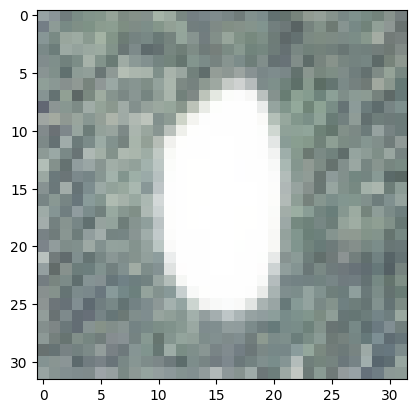

In [0]:
#build a classifier

def manual_classifier(image,area_threshold):
    gray = rgb2gray(image)
    threshold = threshold_otsu(gray)
    binary = gray > threshold
    label_im, nb_labels = ndimage.label(binary)
    regionprops = measure.regionprops(label_im, intensity_image=gray)
    regionprop = regionprops[0]
    area = regionprop.area
    if area > area_threshold:
        return 0
    else:
        return 1

# get a image from test dataset #value must be lower than the size of the test dataset(20-1)
n = 7
image = X_test[n]
label = y_test[n]
area_threshold = 350
prediction = manual_classifier(image,area_threshold)

plt.imshow(image)
print("correct label is: ",label)
print("predicted label is: ",prediction)

# Cara 2 Klasifikasi dengan Support Vector Machine

We will next use Support Vector Machine (SVM) for Classification. Since SVM uses data greater than two dimension (features), we will add another metrics, major_axis_length of the region of interest.

In [0]:
def quantify_mal(image):
    gray = rgb2gray(image)
    threshold = threshold_otsu(gray)
    binary = gray > threshold
    label_im, nb_labels = ndimage.label(binary)
    regionprops = measure.regionprops(label_im, intensity_image=gray)
    regionprop = regionprops[0]
    mal = regionprop.major_axis_length
    return mal


X_train_mal = []
for image in X_train:
    mal = quantify_mal(image)
    X_train_mal.append(mal)

X_test_mal = []
for image in X_test:
    mal = quantify_mal(image)
    X_test_mal.append(mal)

/usr/local/lib/python3.6/dist-packages/skimage/measure/_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
/usr/local/lib/python3.6/dist-packages/skimage/measure/_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)


In [0]:
#reshape data for svm input
X_train2 = np.array([[x,y] for x,y in zip(X_train_mal,X_train_area)])
X_test2 = np.array([[x,y] for x,y in zip(X_test_mal,X_test_area)])
#just concatenating the two data
print(X_train2[:5,:])

[[ 26.8815511  218.        ]
 [ 28.4211966  216.        ]
 [ 25.23602372 209.        ]
 [ 25.44084038 209.        ]
 [ 26.18893877 219.        ]]


In [0]:
#define linear support vector machine for defining the threshold
clf=svm.SVC(kernel="linear")
#train the classifier
clf.fit(X_train2,y_train)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

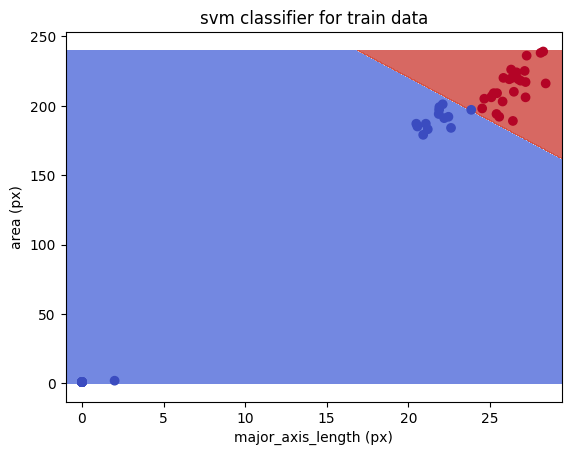

In [0]:
xx, yy = make_meshgrid(X_train2[:,0],X_train2[:,1],h=0.08)
plot_contours(clf, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X_train2[:,0],X_train2[:,1],c=y_train,cmap=plt.cm.coolwarm)
plt.title("svm classifier for train data")
plt.xlabel("major_axis_length (px)")
plt.ylabel("area (px)")
plt.show()

#Coordinates in the red region are classified broken seeds, while blue as proper shaped seeds

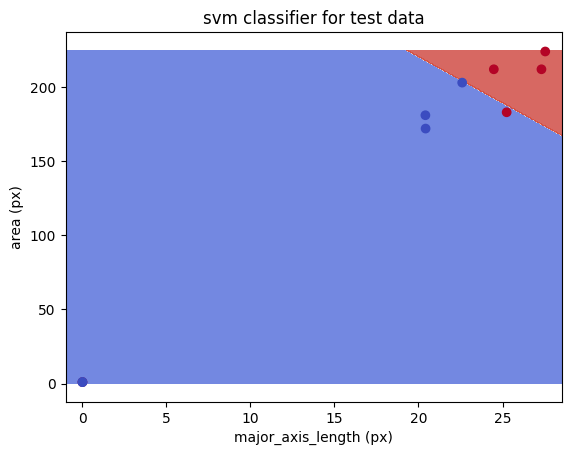

In [0]:
xx, yy = make_meshgrid(X_test2[:,0],X_test2[:,1],h=0.08)
plot_contours(clf, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X_test2[:,0],X_test2[:,1],c=y_test,cmap=plt.cm.coolwarm)
plt.title("svm classifier for test data")
plt.xlabel("major_axis_length (px)")
plt.ylabel("area (px)")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


correct label is:  1
predicted label is:  [0]


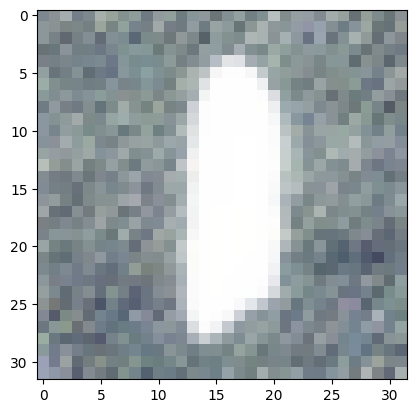

In [0]:
#construct a classifier function
def svm_classifier(clf,image):
    gray = rgb2gray(image)
    threshold = threshold_otsu(gray)
    binary = gray > threshold
    label_im, nb_labels = ndimage.label(binary)
    regionprops = measure.regionprops(label_im, intensity_image=gray)
    regionprop = regionprops[0]
    area = regionprop.area
    result = clf.predict(np.array([1,area]).reshape(1, -1))
    return result
# get a image from test dataset #value must be lower than the size of the test dataset(20-1)
n = 1
image = X_test[n]
label = y_test[n]
prediction = svm_classifier(clf,image)

plt.imshow(image)
print("correct label is: ",label)
print("predicted label is: ",prediction)

# Membedakan 2 Jenis dengan Deep Learning (Convolutional Neural Network)

Finaly, we will use Convolutional Neural Network, a type of deep learning architecture that can handle images. By using CNN, we are freed from defining a suitable feature and only have to feed the images to the network. The CNN will find the most suitable features for classification

In [0]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras import layers
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


## Mempersiapkan Data Masukkan

In [0]:
y_train2 = to_categorical(y_train)
X_train3, _x, y_train3, _y = train_test_split(X_train, y_train2, test_size=1, random_state=42)
y_test2 = to_categorical(y_test)
X_test3, X_valid3, y_test3, y_valid3 = train_test_split(X_test, y_test2, train_size=0.2, random_state=42)

## Pembuatan Model

In [0]:
model = Sequential([
    layers.Conv2D(16, (3,3), input_shape=(32,32,3),name="conv1"),
    layers.Activation("relu"),
    layers.MaxPool2D((2,2),name="pool1"),
    #layers.Dropout(0.25),
    layers.Conv2D(32, (3,3),name="conv2"),
    layers.Activation("relu"),
    layers.MaxPool2D((2,2),name="pool2"),
    #layers.Dropout(0.25),
    layers.Flatten(),
    #layers.Dense(64,name="fc1"),
    #layers.Activation("relu"),
    layers.Dense(2,name="fc"),
    layers.Activation("softmax")
])

model.compile("adam",loss="categorical_crossentropy",metrics=["acc"])
model.summary()







Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 30, 30, 16)        448       
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 16)        0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 15, 15, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 13, 13, 32)        4640      
_________________________________________________________________
activation_2 (Activation)    (None, 13, 13, 32)        0         
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)       

## Pelatihan

In [0]:
history = model.fit(x = X_train3, y = y_train3, batch_size=50, epochs= 100,validation_data=(X_valid3,y_valid3))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 49 samples, validate on 8 samples
Epoch 1/100





49/49 [==============================] - 8s 153ms/step - loss: 0.6900 - acc: 0.5510 - val_loss: 0.6981 - val_acc: 0.5000
Epoch 2/100
49/49 [==============================] - 0s 257us/step - loss: 0.6874 - acc: 0.5102 - val_loss: 0.6869 - val_acc: 0.5000
Epoch 3/100
49/49 [==============================] - 0s 258us/step - loss: 0.6777 - acc: 0.5102 - val_loss: 0.6796 - val_acc: 0.7500
Epoch 4/100
49/49 [==============================] - 0s 241us/step - loss: 0.6723 - acc: 0.7551 - val_loss: 0.6744 - val_acc: 0.8750
Epoch 5/100
49/49 [==============================] - 0s 199us/step - loss: 0.6683 - acc: 0.7347 - val_loss: 0.6694 - val_acc: 0.7500
Epoch 6/100
49/49 [==============================] - 0s 204us/step - loss: 0.6615 - acc: 0.7143 - val_loss: 0.6660 - val_acc: 0.6250
Epoch 7/100
49/49 [==============================] - 0s 2

## Menggambarkan Hasil Pelatihan

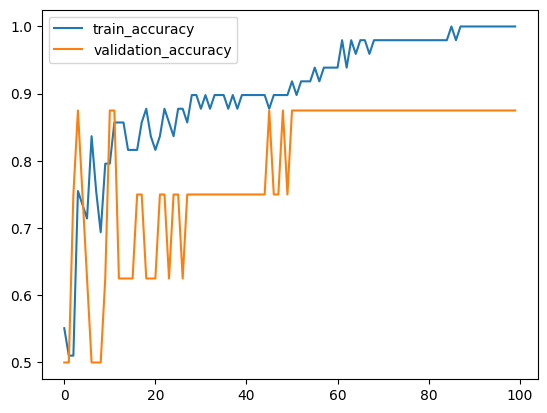

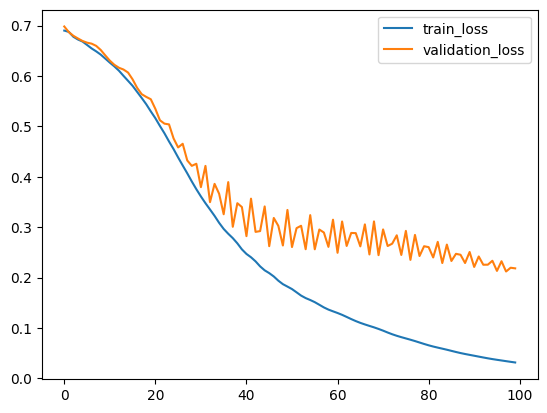

In [0]:
plt.plot(history.history["acc"],label="train_accuracy")
plt.plot(history.history["val_acc"],label="validation_accuracy")
plt.legend()
plt.show()

plt.plot(history.history["loss"],label="train_loss")
plt.plot(history.history["val_loss"],label="validation_loss")
plt.legend()
plt.show()

## Menggunakan Model

In [0]:
print(X_train3.shape)

(49, 32, 32, 3)


In [0]:
n = 35
input_image = X_train3[n][np.newaxis,...]
print("label is: ", y_train3[n])

predictions = model.predict(input_image)
print("prediction is",predictions[0])

label is:  [1. 0.]
prediction is [9.9997401e-01 2.5977883e-05]


See that we just input image and get the results, while step 1 and step 2 required to construct feature(s) by our self.
This seed classification task was quite easy, but the complex the image gets, the harder to construct the most suitable feature gets.
That is when CNN shows its power.
See also the Yeast GFP protein localization tutorial for more complex image classification task.